In [1]:
! pip install tensorflow

     |████████████████████████████████| 489.6 MB 28 kB/s s eta 0:00:011
     |████████████████████████████████| 13.4 MB 63.6 MB/s eta 0:00:01
     |████████████████████████████████| 463 kB 56.2 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 3.7 MB/s  eta 0:00:01
     |████████████████████████████████| 65 kB 12.3 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 15.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 71.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 58.9 MB/s eta 0:00:01
     |████████████████████████████████| 84 kB 8.5 MB/s  eta 0:00:01
     |████████████████████████████████| 5.8 MB 49.4 MB/s eta 0:00:01
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=75ddb5a6b35b9d71e79a547a922b3b8580a97526275b3ae8b06c1f678add3417
  Stored in directory: /home/.cache/pip/wheels/a0/16/9c/5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor
  Attempting uninst

In [1]:
%%time
import tensorflow as tf
import fastai
from fastai.vision.all import *
from pathlib import Path
from zipfile import ZipFile

CPU times: user 3.31 s, sys: 1.2 s, total: 4.5 s
Wall time: 3.78 s


In [3]:
%%time
with ZipFile("/home/flower-classification/flower-classification-with-tpus.zip", 'r') as zip_ref :
    zip_ref.extractall('flowers/')

CPU times: user 15.4 s, sys: 3.84 s, total: 19.2 s
Wall time: 19.8 s


In [4]:
%%time
!git clone https://github.com/pgmmpk/tfrecord.git

Cloning into 'tfrecord'...
remote: Enumerating objects: 20, done.
remote: Total 20 (delta 0), reused 0 (delta 0), pack-reused 20
Unpacking objects: 100% (20/20), 5.32 KiB | 605.00 KiB/s, done.
CPU times: user 92.5 ms, sys: 61.7 ms, total: 154 ms
Wall time: 6.11 s


In [2]:
%%time
#writer = tf.io.TFRecordWriter(FLAGS.output_path)
from tfrecord.tfrecord import *

Instructions for updating:
non-resource variables are not supported in the long term
CPU times: user 5.02 ms, sys: 4.35 ms, total: 9.37 ms
Wall time: 7.58 ms


In [3]:
%%time
def unpack_sample(feats):
    return {
        'class' : unpack_int64_list(feats['class']),
        'image' : unpack_bytes_list(feats['image'])
    }

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [4]:
path = Path.cwd()/"flowers/tfrecords-jpeg-224x224"

In [5]:
path

Path('/home/flower-classification/flowers/tfrecords-jpeg-224x224')

In [6]:
%%time
train_fnames = get_files(path/'train', extensions = '.tfrec')
test_fnames = get_files(path/'val', extensions = '.tfrec')

CPU times: user 2.42 ms, sys: 99 µs, total: 2.52 ms
Wall time: 1.58 ms


In [16]:
%%time
data = []
for name in train_fnames + test_fnames :
    r = Reader(str(name), unpack_sample)
    for sample in r :
        data.append([sample['image'][0], sample['class'][0]])
    #break

CPU times: user 588 ms, sys: 347 ms, total: 936 ms
Wall time: 933 ms


In [19]:
len(data)

16465

In [20]:
16*792

12672

In [21]:
get_x = lambda o : PILImage.create(io.BytesIO(o[0]))
get_y = lambda o : o[1]

In [22]:
def get_items(noop):
    return data

In [25]:
splitter = IndexSplitter(range(12753, len(data)))

In [26]:
block = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items = get_items,
                  get_x = get_x,
                  get_y = get_y, 
                  item_tfms = Resize(224),
                  batch_tfms = [*aug_transforms(min_scale = 0.75)])

In [27]:
dls = block.dataloaders('', bs = 64, device = "cuda")

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


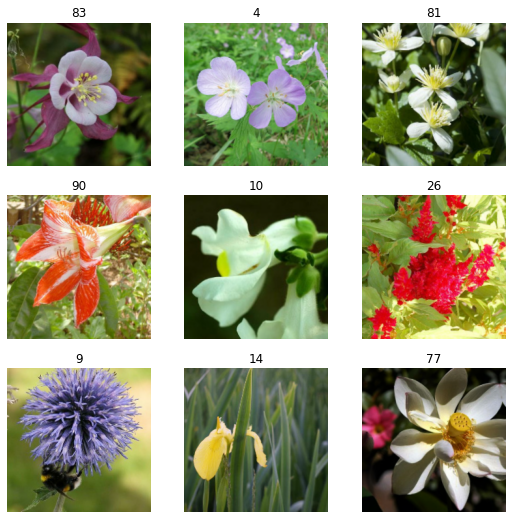

In [29]:
dls.show_batch()

In [31]:
len(dls.vocab)

104